## Commuting data

Files taken from 
- https://statistik.arbeitsagentur.de/SiteGlobals/Forms/Suche/Einzelheftsuche_Formular.html?topic_f=beschaeftigung-sozbe-svb-kreise-merkmale (Sozialversicherungspflichtige Beschäftigte je Kreis / Bundesland)
- https://statistik.arbeitsagentur.de/SiteGlobals/Forms/Suche/Einzelheftsuche_Formular.html?topic_f=beschaeftigung-sozbe-krpend (Pendler)


In [1]:
library(here)
source(here("setup.R"))

suppressPackageStartupMessages({
    library(readxl)
    library(reshape2)
})


here() starts at /Users/stefan/workspace/work/phd/thesis



### Process Commuter data

In [2]:
process_commuters <- function(fname) {
    suppressWarnings({
        state <- read_excel(fname, sheet = "Auspendler Kreise", range = "A4:A4", col_names = F, .name_repair = "unique_quiet")[[1]]

        outcommuters <- read_excel(fname, sheet = "Auspendler Kreise", skip = 6, .name_repair = "unique_quiet") %>%
            tail(-1) %>%
            select("ags_home" = Wohnort, home = 2, "ags_work" = Arbeitsort, work = 4, total = Insgesamt) %>%
            fill(ags_home, home) %>%
            filter(!is.na(work)) %>%
            mutate(total = as.numeric(total))

        incommuters <- read_excel(fname, sheet = "Einpendler Kreise", skip = 6, .name_repair = "unique_quiet") %>%
            tail(-1) %>%
            select("ags_work" = Arbeitsort, work = 2, "ags_home" = Wohnort, home = 4, total = Insgesamt) %>%
            fill(ags_work, work) %>%
            filter(!is.na(home)) %>%
            mutate(total = as.numeric(total))
    })
    list(
        incommuters,
        outcommuters
    )
}
commuters <- here("data/raw") %>%
    # use 2022 data, Eisenach is no longer a county
    list.files(pattern = "krpend*", full.names = T) %>%
    map(process_commuters)

incommuters <- commuters %>%
    map(function(coms) coms[[1]]) %>%
    bind_rows()
outcommuters <- commuters %>%
    map(function(coms) coms[[2]]) %>%
    bind_rows()


### `data/processed/ags_county_dict.csv`

In [3]:
all_ags <- distinct(
    rbind(
        select(incommuters, ags = ags_work, name = work),
        select(incommuters, ags = ags_home, name = home),
        select(outcommuters, ags = ags_work, name = work),
        select(outcommuters, ags = ags_home, name = home)
    ),
    ags, name
)

is_county_ags <- function(ags) str_detect(ags, "^[0-9]{5}$")
is_state_ags <- function(ags) str_detect(ags, "^[0-9]{2}$")

all_county_ags <- all_ags %>%
    filter(is_county_ags(ags))
write_csv(all_county_ags, here("data/processed/ags_county_dict.csv"))

all_state_ags <- all_ags %>%
    filter(is_state_ags(ags)) %>%
    filter(!name == "Übrige Regierungsbezirke (Bundesland)")
write_csv(all_state_ags, here("data/processed/ags_state_dict.csv"))


In [4]:
stopifnot(all_state_ags %>% nrow() == 16)
stopifnot(all_county_ags %>% nrow() == 400)


### `data/processed/{incommuters.csv,outcommuters.csv}`

In [5]:
complete_ags <- all_county_ags$ags

outcommuters_complete <- outcommuters %>%
    select(ags_work, ags_home, total) %>%
    filter(is_county_ags(ags_work), is_county_ags(ags_home)) %>%
    complete(ags_work = complete_ags, ags_home = complete_ags, fill = list(total = 0))

incommuters_complete <- incommuters %>%
    select(ags_work, ags_home, total) %>%
    filter(is_county_ags(ags_work), is_county_ags(ags_home)) %>%
    complete(ags_work = complete_ags, ags_home = complete_ags, fill = list(total = 0))

stopifnot(
    "Outcommuters are not unique" = nrow(outcommuters_complete) == length(complete_ags)^2,
    "Incommuters are not unique" = nrow(incommuters_complete) == length(complete_ags)^2
)
write_csv(
    outcommuters_complete,
    here("data/processed/outcommuters.csv")
)
write_csv(
    incommuters_complete,
    here("data/processed/incommuters.csv")
)


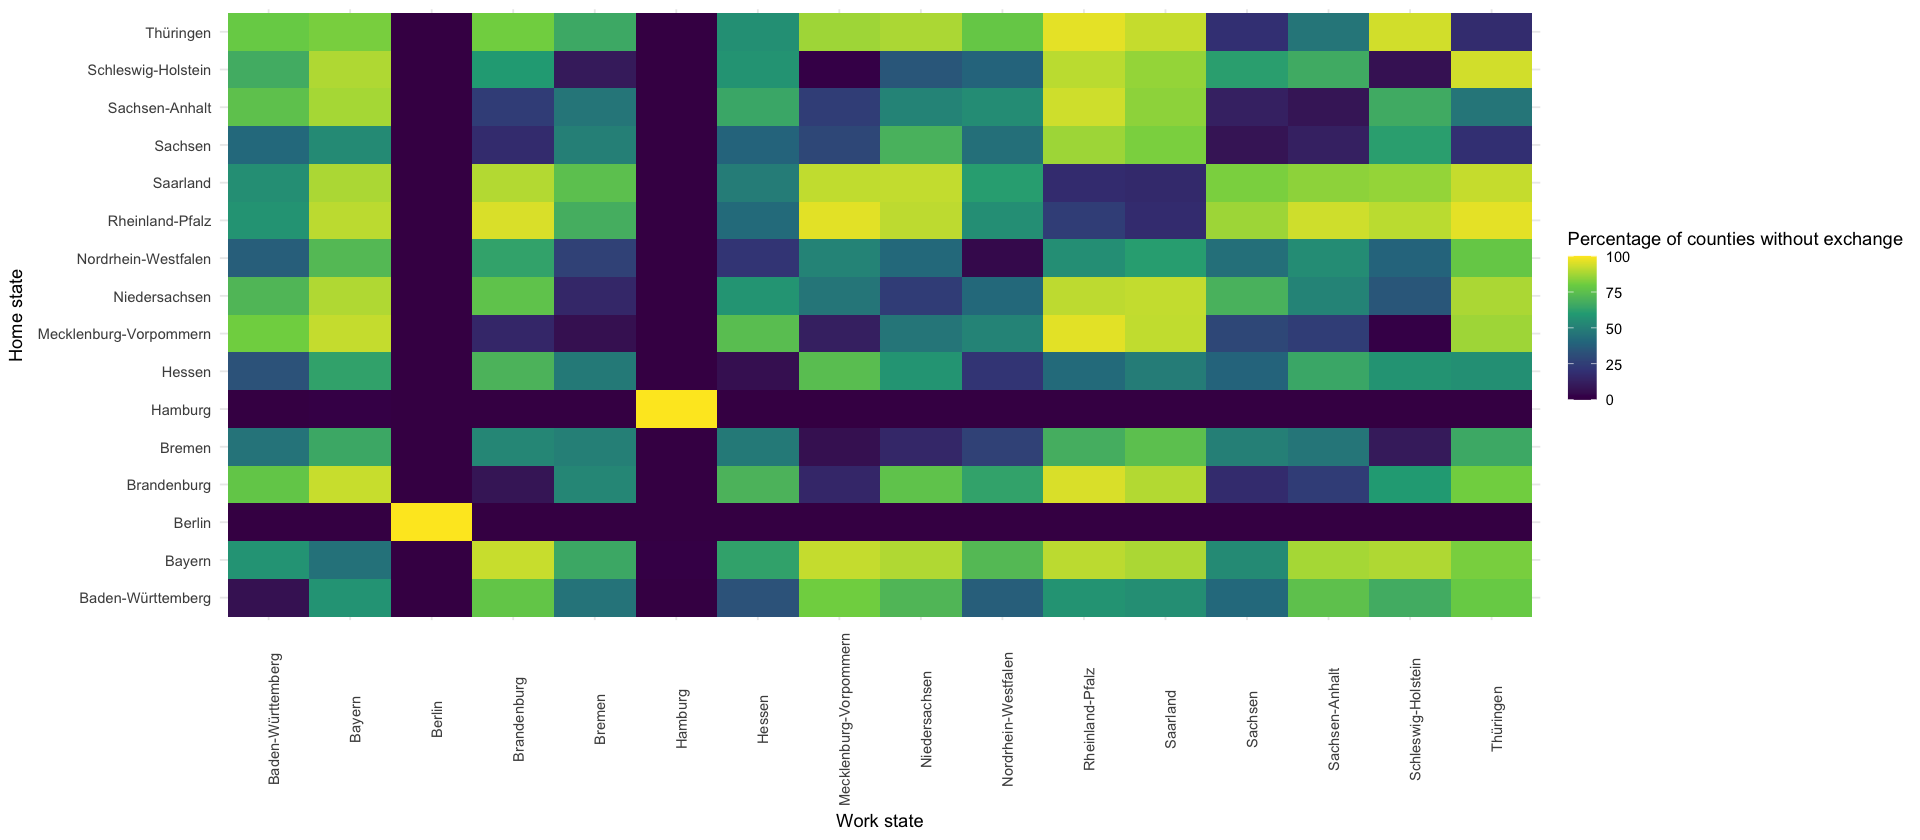

In [6]:
inner_join(
    incommuters_complete,
    outcommuters_complete,
    by = c("ags_work" = "ags_home", "ags_home" = "ags_work"),
    suffix = c("_in", "_out")
) %>%
    group_by(state_work = str_sub(ags_work, 0, 2), state_home = str_sub(ags_home, 0, 2)) %>%
    summarize(
        pct_no_exchange = mean(total_in + total_out == 0) * 100
    ) %>%
    inner_join(rename(all_state_ags, work = name), by = c("state_work" = "ags")) %>%
    inner_join(rename(all_state_ags, home = name), by = c("state_home" = "ags")) %>%
    ggplot(aes(x = work, y = home, fill = pct_no_exchange)) +
    geom_tile() +
    scale_fill_viridis_c() +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 90)) +
    labs(
        x = "Work state",
        y = "Home state",
        fill = "Percentage of counties without exchange"
    )


### Sozialversicherungsbeschäftigte
Hier die passenden Daten ab September '21 nehmen; ab September 21 ist Eisenach kein eigener Kreis mehr (und kommt in den RKI Zahlen nicht mehr vor).

### `data/processed/{work_totals.csv,home_totals.csv}`

In [7]:
work_totals <- read_excel(here("data/raw/svb-kreise-merkmale-d-0-202109-xlsx.xlsx"), sheet = 3, skip = 6, .name_repair = "unique_quiet") %>%
    select(name = 1, ags = 2, total = 3) %>%
    filter(is_county_ags(ags))
home_totals <- read_excel(here("data/raw/svb-kreise-merkmale-d-0-202109-xlsx.xlsx"), sheet = 4, skip = 6, .name_repair = "unique_quiet") %>%
    select(name = 1, ags = 2, total = 3) %>%
    filter(is_county_ags(ags))

write_csv(
    work_totals,
    here("data/processed/work_totals.csv")
)
write_csv(
    home_totals,
    here("data/processed/home_totals.csv")
)


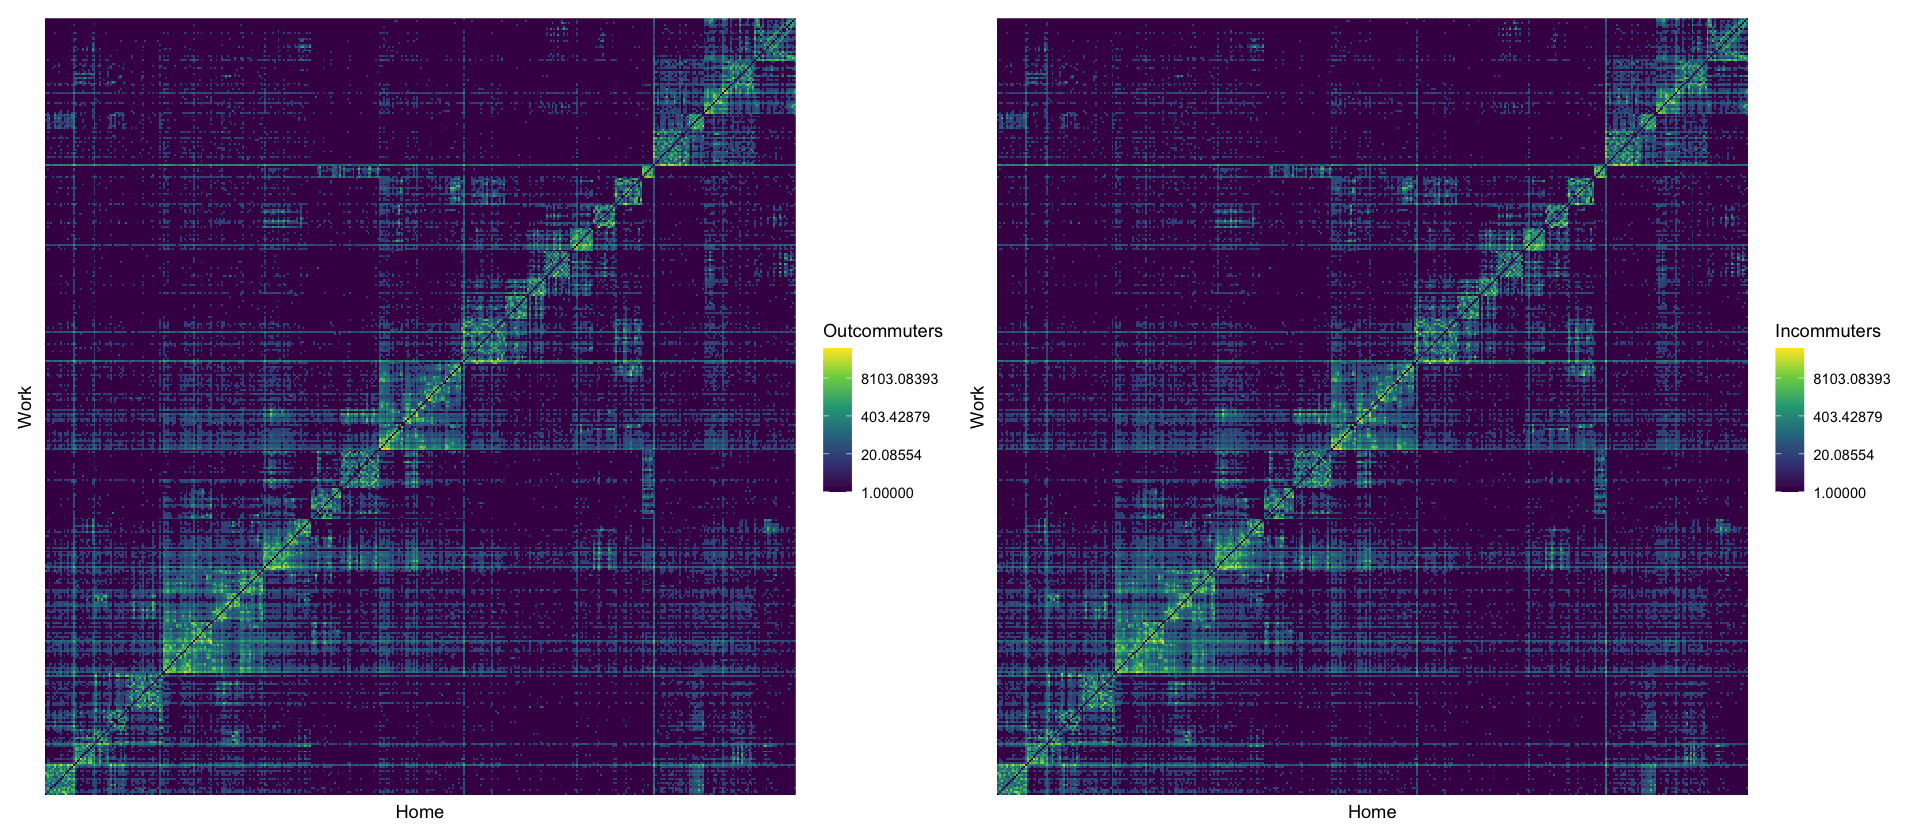

In [8]:
stopifnot(work_totals %>% nrow() == 400)
stopifnot(home_totals %>% nrow() == 400)

p_out <- outcommuters_complete %>%
    arrange(ags_home, ags_work) %>%
    ggplot(aes(ags_home, ags_work, fill = (total + 1))) +
    geom_tile() +
    scale_fill_viridis_c(trans = "log") +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank()) +
    labs(x = "Home", y = "Work", fill = "Outcommuters")

p_in <- incommuters_complete %>%
    arrange(ags_home, ags_work) %>%
    ggplot(aes(ags_home, ags_work, fill = (total + 1))) +
    geom_tile() +
    scale_fill_viridis_c(trans = "log") +
    theme(axis.text.x = element_blank(), axis.ticks.x = element_blank()) +
    theme(axis.text.y = element_blank(), axis.ticks.y = element_blank()) +
    labs(x = "Home", y = "Work", fill = "Incommuters")

p_out | p_in


# RKI data

In [9]:
options(timeout = max(300, getOption("timeout")))
if (!file.exists(here("data/raw/RKI.csv"))) {
    download.file(
        "https://zenodo.org/records/10638065/files/Aktuell_Deutschland_SarsCov2_Infektionen.csv?download=1", here("data/raw/RKI.csv")
    )
}


WHO declares end of COVID-19 health crisis on May 5th 2023 (https://www.who.int/director-general/speeches/detail/who-director-general-s-opening-remarks-at-the-media-briefing---5-may-2023). Measures in Germany ended shortly before (April 2023), so weu se May 5th as final date (can also see reporting drop sharply in spring 2023).

In [10]:
final_date <- ymd("2023-05-05")


In [11]:
rki_no_meta <- read_csv(here("data/raw/RKI.csv"))
rki_metadata <- read_csv(here("data/raw/RKI_meta.csv"))

rki_no_meta$IdLandkreis <- str_pad(
    rki_no_meta$IdLandkreis,
    5,
    "left",
    "0"
)
rki <- inner_join(rki_no_meta, rki_metadata, by = "IdLandkreis")

rki$Meldedatum <- as.Date(rki$Meldedatum)
rki$Refdatum <- as.Date(rki$Refdatum)


In [12]:
# RKI also reports differences to yesterdays publication
# current days cases / deaths are only those where "Anzahl(Todes)Fall" is >= 0
rki[rki$NeuerFall < 0, "AnzahlFall"] <- 0
rki[rki$NeuerTodesfall < 0, "AnzahlTodesfall"] <- 0

rki <- filter(rki, Meldedatum <= final_date)


In [13]:
rki_county <- rki
county_cases <- NULL

berlin_ids <- 11000:11012
rki_county[rki_county$IdLandkreis %in% berlin_ids, c("Landkreis", "IdLandkreis")] <- list("LK Berlin", "11000")
county_cases <- aggregate(cbind(cases = AnzahlFall, deaths = AnzahlTodesfall) ~ Meldedatum + Bundesland + Landkreis, data = rki_county, sum)
colnames(county_cases)[1:3] <- c("reporting_date", "state", "county")
county_cases <- complete(county_cases,
    reporting_date = seq(min(reporting_date), max(reporting_date), by = "1 day"),
    nesting(state, county),
    fill = list(cases = 0, deaths = 0)
)


## `data/processed/RKI_county.csv`

In [14]:
county_cases %>%
    inner_join(
        rbind(
            rki_metadata,
            list(IdBundesland = 11, Bundesland = "Berlin", IdLandkreis = "11000", Landkreis = "LK Berlin")
        ) %>%
            arrange(IdLandkreis),
        by = c("county" = "Landkreis")
    ) %>%
    select(date = reporting_date, ags = IdLandkreis, cases, deaths) %>%
    write_csv(here("data/processed/RKI_county.csv"))


## `data/processed/RKI_county_weekly.csv` 

We use the weekly format [required in the ECDCs ForecastHub](https://github.com/european-modelling-hubs/covid19-forecast-hub-europe/wiki/targets-and-horizons#Date-format):
> Forecast horizons should use the Epidemiological Week (EW) format, defined by the US CDC. Each week starts on Sunday and ends on Saturday. 

In [17]:
county_cases %>%
    inner_join(
        rbind(
            rki_metadata,
            list(IdBundesland = 11, Bundesland = "Berlin", IdLandkreis = "11000", Landkreis = "LK Berlin")
        ) %>%
            arrange(IdLandkreis),
        by = c("county" = "Landkreis")
    ) %>%
    select(date = reporting_date, ags = IdLandkreis, cases, deaths) %>%
    group_by(date = ceiling_date(date, "week", week_start = 7), ags) %>%
    summarize(cases = sum(cases), deaths = sum(deaths)) %>%
    write_csv(here("data/processed/RKI_county_weekly.csv"))


In [16]:
rki_ags <- unique(rki_county$IdLandkreis)
commuters_ags <- unique(outcommuters$ags_home)

stopifnot(length(c(setdiff(commuters_ags, rki_ags), setdiff(rki_ags, commuters_ags))) == 0)
